In [1]:
#%pip install qiskit qiskit_aer matplotlib pylatexenc

--- Sequential BV (measure-at-end) ---


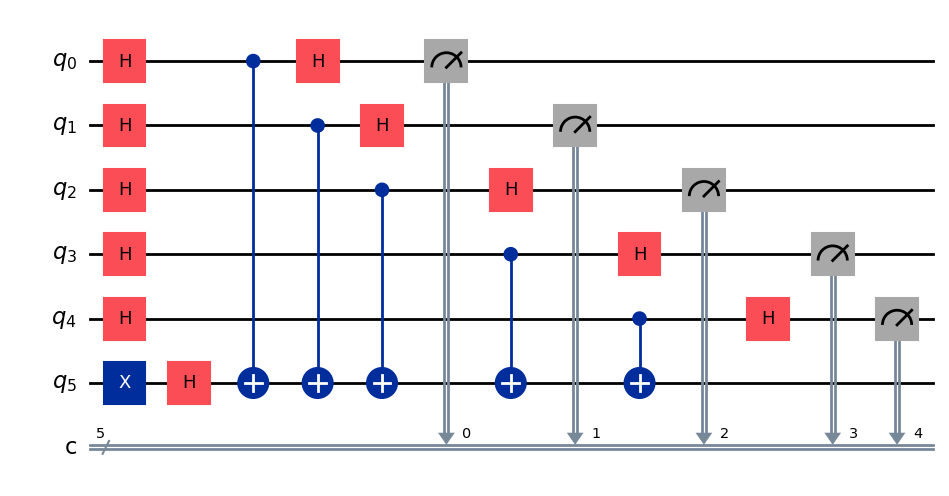

In [2]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode

s = '11111'
n = len(s)
qc_seq = QuantumCircuit(n + 1, n)

# Ancilla prep
qc_seq.x(n)
qc_seq.h(n)

for i in range(n):
    qc_seq.h(i)
    if s[n - 1 - i] == '1':
        qc_seq.cx(i, n)
    qc_seq.h(i)

for i in range(n):
    qc_seq.measure(i, i)

print("--- Sequential BV (measure-at-end) ---")
display(qc_seq.draw('mpl'))


Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

--- Optimized Circuit ---
Depth: 25
Qubits: 6
Reused 4 qubit(s)
Reuse chain: [(0, 1), (0, 2), (0, 3), (0, 4)]


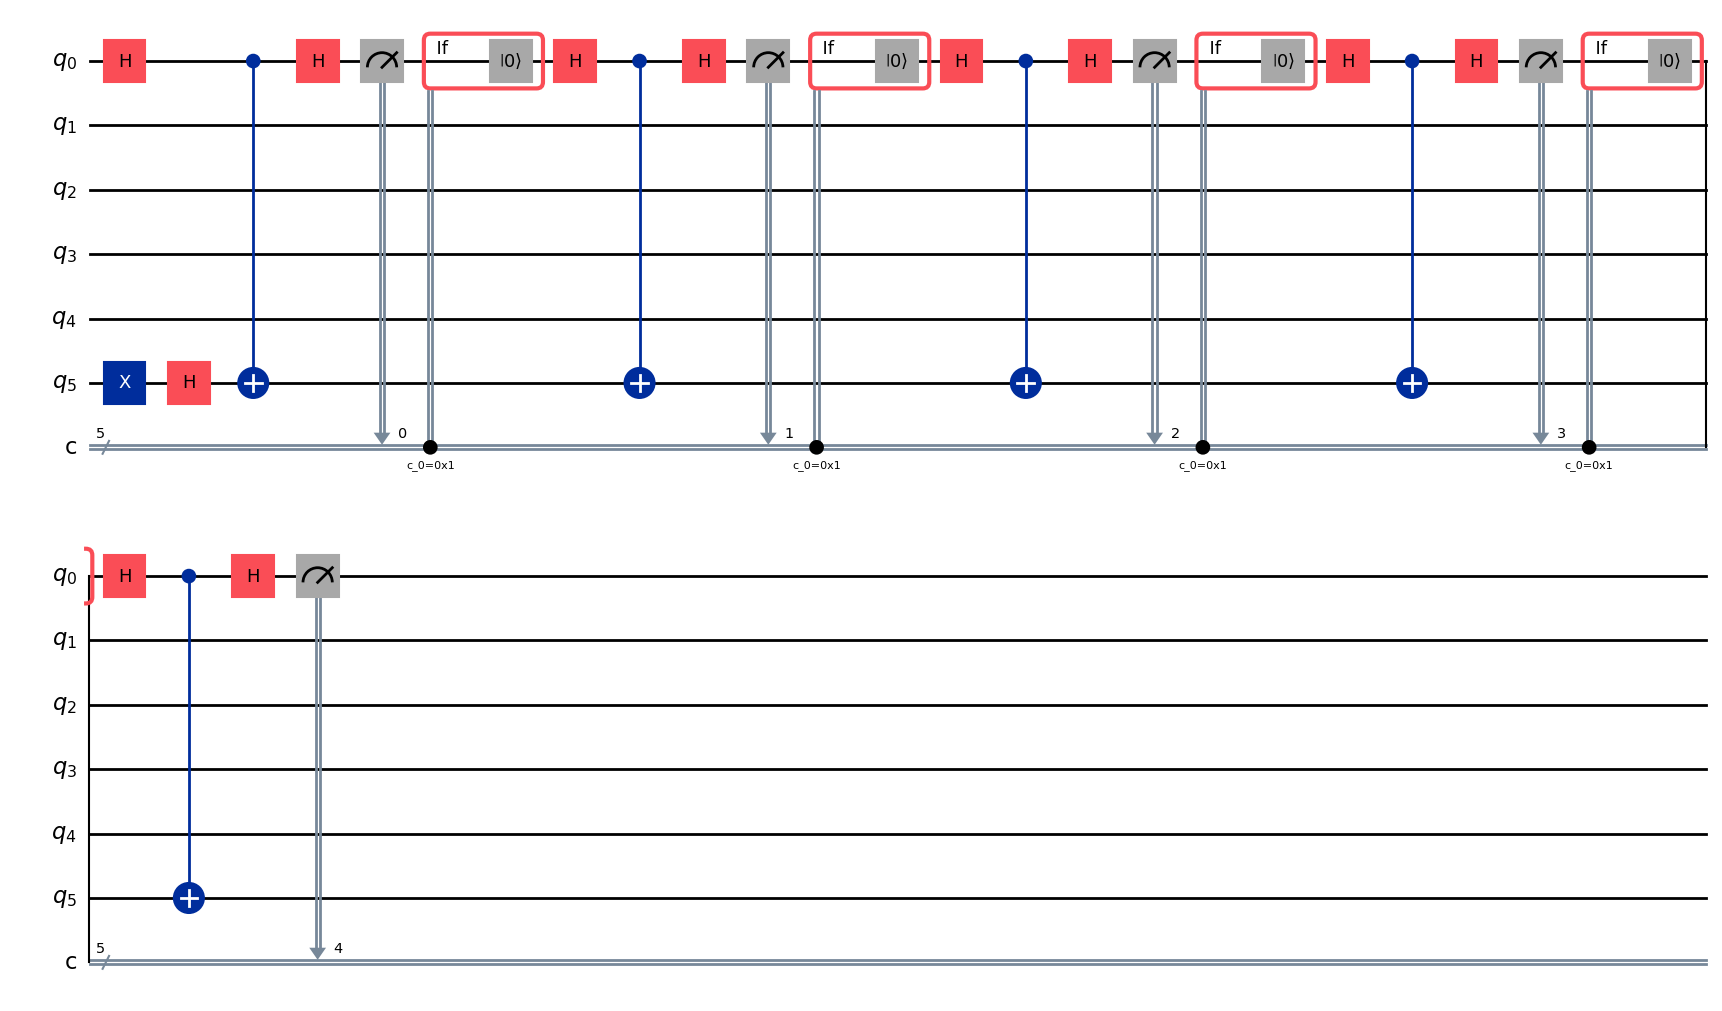

In [3]:
from circuit_analysis import find_qubit_reuse_pairs, modify_circuit, last_index_operation, first_index_operation
import sys

cur_qc = qc_seq.copy()
reuse_pairs = find_qubit_reuse_pairs(cur_qc)
print(f"\nInitial reusable pairs: {reuse_pairs}")
iter_count = 0
chain = []
weight = (1, 1, 1)


while len(reuse_pairs) > 0 and iter_count < len(qc_seq.qubits) - 1:
    depth_diff = sys.maxsize    
    lst_index = last_index_operation(cur_qc)
    fst_index = first_index_operation(cur_qc)
    
    for i in range(len(reuse_pairs)):
        test_qc = cur_qc.copy()
        test_out_qc = modify_circuit(test_qc, reuse_pairs[i])

        if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + weight[1]* lst_index[reuse_pairs[i][0]]+weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
            depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
            best_pair = reuse_pairs[i]

    # print(f"Best pair: {best_pair}")
    chain.append((best_pair[0], best_pair[1]))
    modified_qc = modify_circuit(cur_qc, best_pair)
    # print(modified_qc)

    reuse_pairs = find_qubit_reuse_pairs(modified_qc)
    cur_qc = modified_qc.copy()
    iter_count += 1
    lst_index = last_index_operation(cur_qc)

print(f"\n--- Optimized Circuit ---")
print(f"Depth: {cur_qc.depth()}")
print(f"Qubits: {cur_qc.num_qubits}")
print(f"Reused {iter_count} qubit(s)")
print(f"Reuse chain: {chain}")
display(cur_qc.draw('mpl'))

In [4]:
#print(cur_qc)
print(modified_qc)

     ┌───┐          ┌───┐┌─┐  ┌──────        ───────┐ ┌───┐     ┌───┐┌─┐»
q_0: ┤ H ├───────■──┤ H ├┤M├──┤ If-0  ──|0>─  End-0 ├─┤ H ├──■──┤ H ├┤M├»
     └───┘       │  └───┘└╥┘  └──╥───        ───────┘ └───┘  │  └───┘└╥┘»
q_1: ────────────┼────────╫──────╫───────────────────────────┼────────╫─»
                 │        ║      ║                           │        ║ »
q_2: ────────────┼────────╫──────╫───────────────────────────┼────────╫─»
                 │        ║      ║                           │        ║ »
q_3: ────────────┼────────╫──────╫───────────────────────────┼────────╫─»
                 │        ║      ║                           │        ║ »
q_4: ────────────┼────────╫──────╫───────────────────────────┼────────╫─»
     ┌───┐┌───┐┌─┴─┐      ║      ║                         ┌─┴─┐      ║ »
q_5: ┤ X ├┤ H ├┤ X ├──────╫──────╫─────────────────────────┤ X ├──────╫─»
     └───┘└───┘└───┘      ║ ┌────╨────┐                    └───┘      ║ »
c: 5/═════════════════════╩═╡ c_0=0x1 

In [5]:
# #THIS IS SO COOKED: THE DOCUMENTATION VERSION IS NOT AVAILABLE TO INSTALL AND THE LATEST VERSION INTRODUCES THIS FUNCTION
# from mqt.qecc.circuit_synthesis.circuit_utils import 

# stim_circuit = (cur_qc)
# print(stim_circuit)

In [6]:
# #THIS IS ALSO GIGA COOKED: ERROR WITHIN THE LIBRARY
# from qiskit_qec.utils import get_stim_circuits


# test_qc_seq = QuantumCircuit(n + 1, n)
# test_qc_seq.h(n)

# for i in range(n):
#     test_qc_seq.h(i)
#     if s[n - 1 - i] == '1':
#         test_qc_seq.cx(i, n)
#     test_qc_seq.h(i)

# for i in range(n):
#     test_qc_seq.measure(i, i)

# print("--- Sequential BV (measure-at-end) ---")
# display(test_qc_seq.draw('mpl'))

# stim_circuit = get_stim_circuits(test_qc_seq)
# print(stim_circuit)